In [1]:
#%% Imports
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import "local" packages
import hyspec_io, hyspec_ml, image_render, preprocess 

2024-02-21 09:07:06.750066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#%% Paths
tmp_save_dir = Path('/media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint')
im_paths = ['/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_31-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_32-Crop Wavelengths.bip.hdr', # første eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_79-Crop Wavelengths.bip.hdr', # dyp sand midt i bildet
            '/media/mha114/Massimal2/Massimal/Smola_Skalmen/Hyperspectral/20230620/2a_Rrs/Skardskjaringen_Pika_L_81-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_24-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_30-Crop Wavelengths.bip.hdr', # godt eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_02_Pika_L_42-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_20-Crop Wavelengths.bip.hdr', # godt eksempel
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_25-Crop Wavelengths.bip.hdr',
            '/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr'] # godt eksempel
im_paths = [Path(p) for p in im_paths]


In [3]:
for im_path in im_paths[-1:]:
    (im,wl,rgb_ind,metadata) = hyspec_io.load_envi_image(im_path)

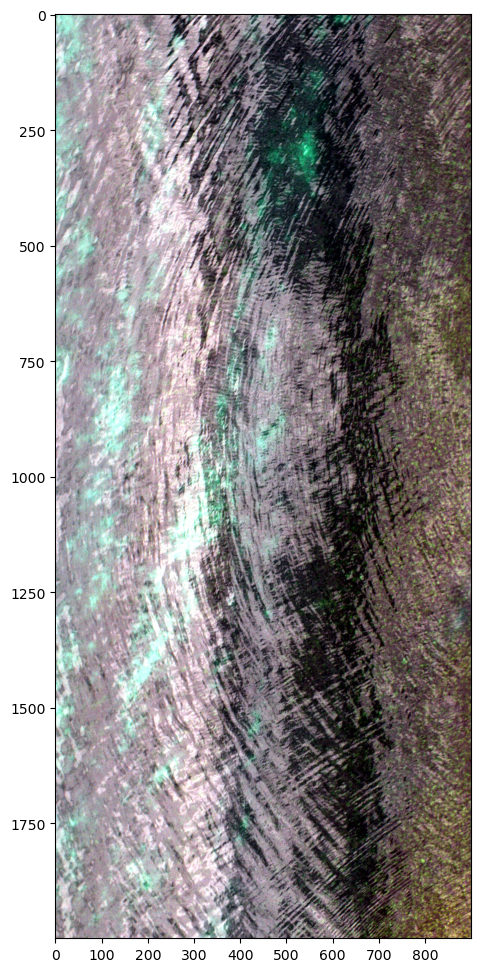

In [4]:
#%% Show RGB
fig,ax = plt.subplots(ncols=1,figsize=(10,12))
ax.imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
#ax[1].imshow(image_render.percentile_stretch(im_nir,separate_bands = False),cmap='gray')
plt.show()

In [5]:
# Vectorize image
im_vectorizer = hyspec_ml.ImageVectorizer(nRows=im.shape[0],nCols=im.shape[1])
im_2d = im_vectorizer.image3d_to_matrix(im)
print(f'Shape of original image: {im.shape}')
print(f'Shape of vectorized image: {im_2d.shape}')

Shape of original image: (2000, 900, 255)
Shape of vectorized image: (1800000, 255)


In [6]:
# Z-score transform
z_scaler = StandardScaler()
im_2d_norm = z_scaler.fit_transform(im_2d)

In [7]:
# PCA transform 
pca = PCA(n_components=6)
im_2d_pca = pca.fit_transform(im_2d_norm)

In [8]:
im_pca = im_vectorizer.matrix_to_image3d(im_2d_pca)
print(f'Shape of PCA image: {im_pca.shape}')

Shape of PCA image: (2000, 900, 6)


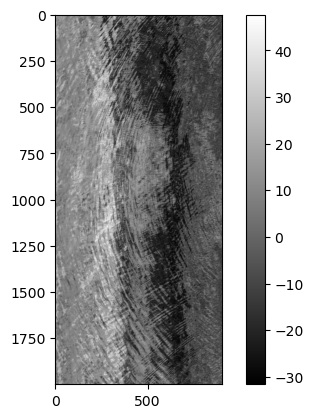

In [9]:
plt.imshow(im_pca[:,:,0],cmap='gray')
plt.colorbar()
plt.show()

In [10]:
X_mean = pca.mean_
W_pca = pca.components_
print(W_pca.shape)

(6, 255)


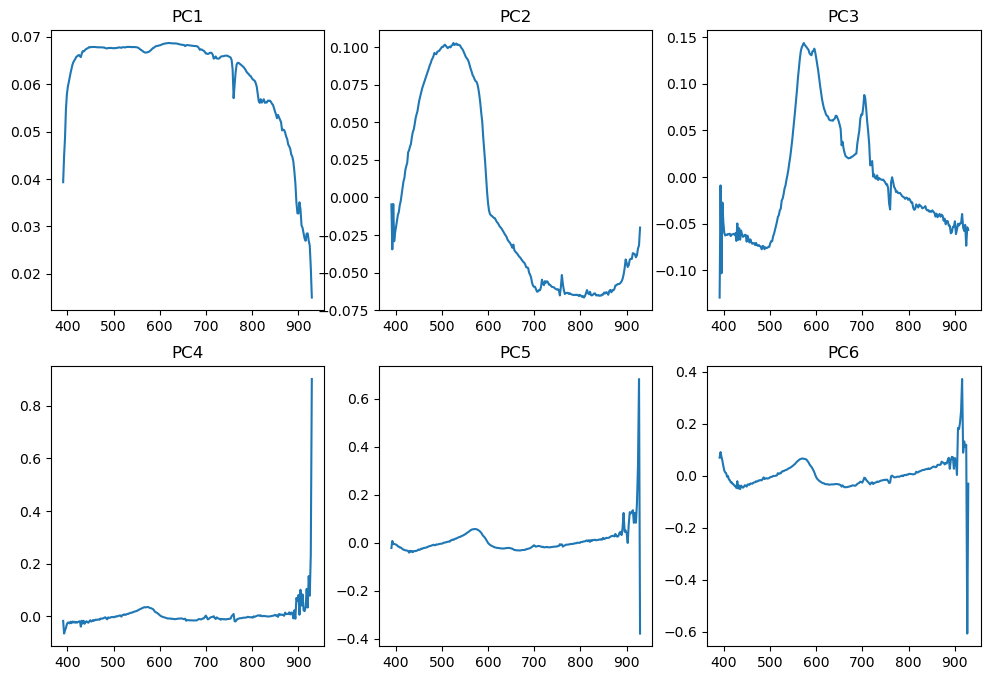

In [28]:
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(12,8))
for i,ax in enumerate(axes.reshape(-1)):
    ax.plot(wl,W_pca[i])
    ax.set_title(f'PC{i+1}')
plt.show()

# Note on principal component shape
The principal components shown here (based on normalized spectra) are different from the components calculated based on non-normalized spectra. 
- In both cases, PC1 looks fairly "flat". With normalization, it's fairly smooth, and also tapers off towards the high and low end. Without normalization, PC1 looks much more "noisy", and does not taper off as much.
- PC2 looks very similar to the typical "deep sand" spectrum.
- PC3 has similarities to algae spectra, with a peak around 600 nm, a small peak/shoulder at 640 nm, a dip at 670 nm and part of the red edge around 700 nm. 

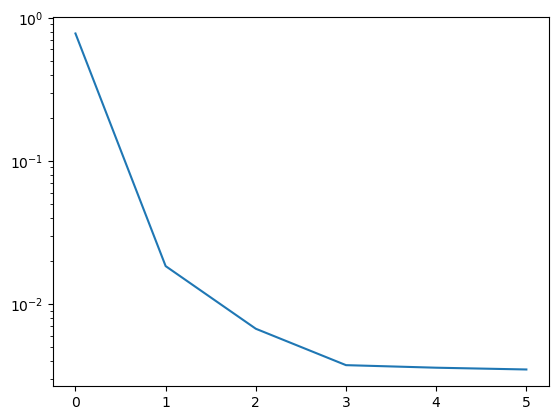

In [24]:
# Show explained varance 
plt.semilogy(pca.explained_variance_ratio_) 
plt.show()

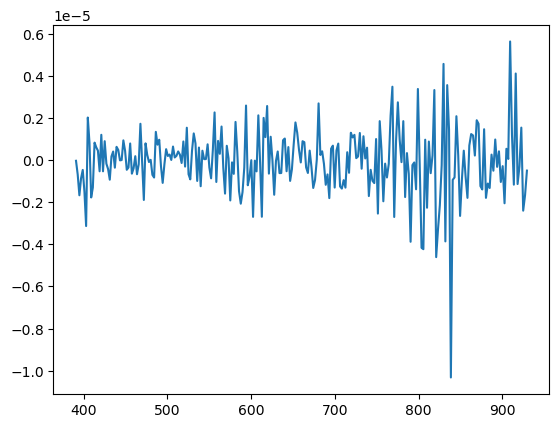

In [12]:
plt.plot(wl,X_mean)

In [13]:
pc1 = W_pca[0]
pc1 = pc1.reshape((1,-1))
print(pc1.shape)

(1, 255)


In [14]:
# Construct glint image based on PC1
im_2d_pc1 = im_2d_pca[:,0:1]
im_2d_glint = im_2d_pc1*pc1 
im_glint = im_vectorizer.matrix_to_image3d(im_2d_glint)
print(im_2d_glint.shape)

(1800000, 255)


In [15]:
# Subtract glint from original (normalized) image, and reverse normalization  
im_noglint = im_vectorizer.matrix_to_image3d(z_scaler.inverse_transform(im_2d_norm - im_2d_glint))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


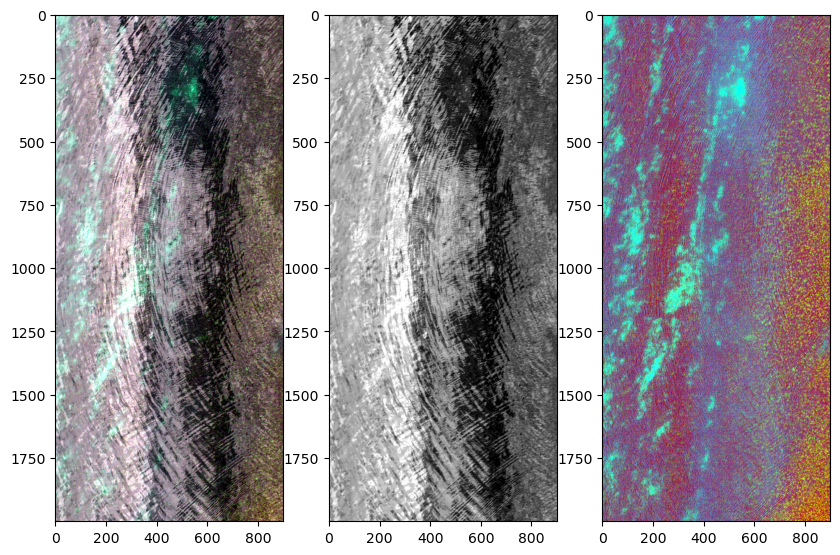

In [16]:
fig,ax = plt.subplots(ncols=3,figsize=(10,12))
ax[0].imshow(image_render.percentile_stretch(im[:,:,rgb_ind]))
ax[1].imshow(image_render.percentile_stretch(im_glint[:,:,rgb_ind]))
ax[2].imshow(image_render.percentile_stretch(im_noglint[:,:,rgb_ind]))
plt.show()

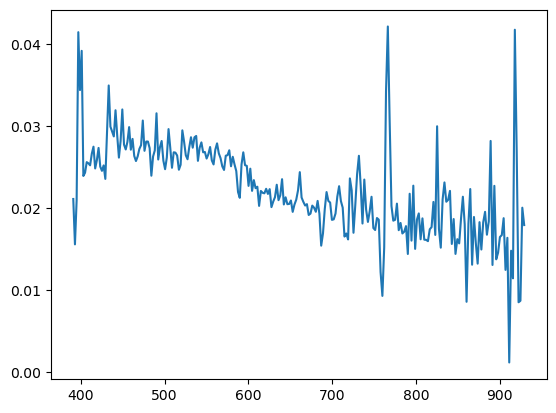

In [17]:
plt.plot(wl,im_noglint[1000,600,:])

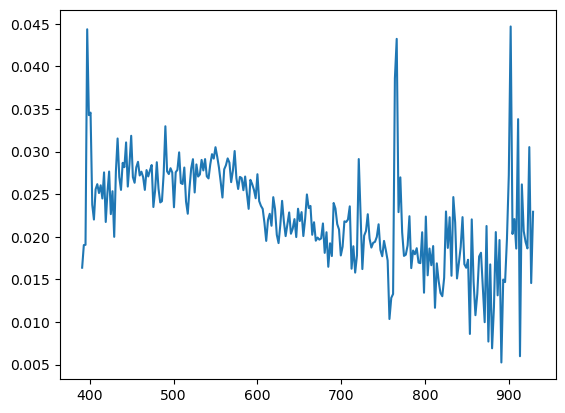

In [18]:
plt.plot(wl,im_noglint[850,150,:])

In [19]:
im_path

PosixPath('/media/mha114/Massimal2/Massimal/Smola_Maholmen/Hyperspectral/20230621/2a_Rrs/Maholmen_03_Pika_L_32-Crop Wavelengths.bip.hdr')

In [38]:
# Update metadata
metadata_mod = metadata.copy()
metadata_mod['history'] += ' -> SunGlintCorrectPCA'
print(metadata_mod['history'])

input cube -> ReflectivityConversion<SpecGroup>[<SpecFloat label:'Saturation Value' value:4095.0>, <SpecBool label:'Set saturated pixels to zero?' value:True>, <SpecSpectrum label:'Correlation Coefficients' value:None>, <SpecBool label:'Use Correlation Coefficients' value:False>, <SpecChoice label:'Scale 100% Reflectivity To:' value:1.0 (floats)>, <SpecFilename label:'Downwelling Offset' value:>, <SpecSpectrum label:'Downwelling Dark Spectrum' value:None>, <SpecBool label:'Auto Remove Downwelling Dark Noise?' value:True>, <SpecFilename label:'Downwelling Calibration' value:F:\Smola_Maholmen\Hyperspectral\20230621\_Calibration\FLMS16638_Radiometric_Jan2021.dcp>, <SpecSpectrum label:'Downwelling Spectrum' value:None>, <SpecBool label:'Use Downwelling Spectrum in Source Folder' value:True>, <SpecChoice label:'Downwelling Type' value:Resonon Calibrated>, <SpecCube label:'Dark Noise Cube' value:None>, <SpecBool label:'Auto Remove Dark Noise?' value:True>, <SpecFilename label:'Imager Calibra

In [39]:
# Create new file name
file_base, file_ext = im_path.name.split('.',maxsplit=1)
save_file_path = tmp_save_dir / (file_base + '_PCASGC.' + file_ext) 
print(f'Saving image to file {save_file_path}')

Saving image to file /media/mha114/Massimal2/Massimal/X_TemporaryDeletableFiles/PrelimSkalmenDeglint/Maholmen_03_Pika_L_32-Crop Wavelengths_PCASGC.bip.hdr


In [40]:
# Save image
hyspec_io.save_envi_image(str(save_file_path),im_noglint,metadata_mod)